## Load replay buffer

In [6]:
import torch
import os
from src.utils import load_replay_buffer
from src.learning.symmetry.kernel_approx import KernelFrameEstimator

LEARN_KERNEL_BASES: bool=True
folder_name: str="data/local/experiment/circle_rotation"
TASK_NAMES=["sac_circle_rotation_task_0", "sac_circle_rotation_task_1", "sac_circle_rotation_task_2", "sac_circle_rotation_task_3"]
N_SAMPLES:int=50_000
KERNEL_DIM=1
EPSILON_BALL = 0.005
EPSILON_LEVEL_SET = 0.0025

def load_data(task_name, kernel_in, kernel_out, n_samples, folder_name:str):
    """
    Load data from the replay buffer.
    """
    replay_buffer_name:str=os.path.join(folder_name,task_name+"_replay_buffer.pkl")
    replay_buffer = load_replay_buffer(replay_buffer_name, N_steps=n_samples)
    assert kernel_in in replay_buffer.keys(), f"Kernel input {kernel_in} not found in replay buffer keys: {replay_buffer.keys()}"
    assert kernel_out in replay_buffer.keys(), f"Kernel output {kernel_out} not found in replay buffer keys: {replay_buffer.keys()}"
    
    ps = replay_buffer[kernel_in]
    ns = replay_buffer[kernel_out]
    
    return ps, ns


def learn_kernel_bases(task_name: str, kernel_in, kernel_out, n_samples: int, kernel_dim: int, epsilon_ball: float, epsilon_level_set: float):
    """
    Learn kernel bases from the replay buffer.
    """
    ps, ns=load_data(task_name, kernel_in, kernel_out, n_samples, folder_name)

    frame_estimator = KernelFrameEstimator(ps=ps, kernel_dim=kernel_dim, ns=ns, epsilon_ball=epsilon_ball, epsilon_level_set=epsilon_level_set)
    frame_estimator.compute()

    kernel_bases_name = f"{task_name}_kernel_bases.pkl"
    frame_estimator.save(kernel_bases_name)
    
    return frame_estimator

In [7]:
frame_estimators=[]
if LEARN_KERNEL_BASES:
    kernel_in = f"next_observations"
    kernel_out = f"rewards"
    for task_name in TASK_NAMES:
        frame_estimator=learn_kernel_bases(task_name, "next_observations", "rewards", N_SAMPLES, KERNEL_DIM, EPSILON_BALL, EPSILON_LEVEL_SET)
        frame_estimators.append(frame_estimator)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_approx.py:55: UserWarning: TODO: Dimension of kernel should be actively inferred, not passed as an argument.
  warnings.warn("TODO: Dimension of kernel should be actively inferred, not passed as an argument.")
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_approx.py:138: UserWarning: Kernel Approximation currently only supports real-valued functions.
  warnings.warn("Kernel Approximation currently only supports real-valued functions.")
INFO:root:Computing neighborhood of samples via kdtree...
Compute Point-Wise Bases via PCA...: 100%|██████████| 100000/100000 [00:06<00:00, 15550.34it/s]
INFO:root:Computed kernel bases from:
  - multiple 

## Extrapolate via KDE

INFO:root:Setup kernel frame evaluation.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")


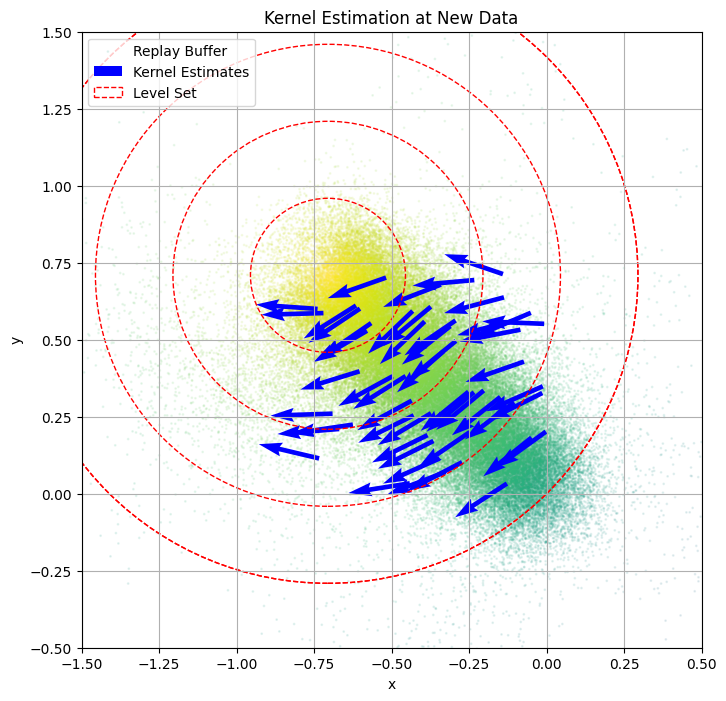

In [9]:
import numpy as np

import matplotlib.pyplot as plt
TASK_IDX_DEMO=0
frameestimator=frame_estimators[TASK_IDX_DEMO]
frameestimator.setup_evaluation()
ps, ns= load_data(TASK_NAMES[TASK_IDX_DEMO], "next_observations", "rewards", N_SAMPLES, folder_name)

num_points = 50
x = np.random.uniform(-0.75, 0, num_points)
y = np.random.uniform(0, 0.75, num_points)
points = np.stack([x, y], axis=1)
points_th=torch.tensor(points, dtype=torch.float32)
vectors=frameestimator.evaluate(points_th, bandwidth=0.05)


vectors = np.array(vectors)
plt.figure(figsize=(8, 8))
plt.scatter(ps[:, 0], ps[:, 1], c=ns, s=1, alpha=0.1, label="Replay Buffer")
plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1], angles='xy', scale_units='xy', scale=5, color='blue', label="Kernel Estimates")

goal = np.array([-0.70506063, 0.70914702])
circle_radii = [0.25, 0.5, 0.75, 1]
for radius in circle_radii:
    circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--', label="Level Set")
plt.gca().add_artist(circle)

plt.xlim(-1.5, 0.5)
plt.ylim(-0.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Kernel Estimation at New Data')
plt.grid()
plt.show()

In [3]:
import torch

def rotation_vector_field(p_batch: torch.tensor, center)->torch.tensor:
    """Returns kernel samples at batched points p from a task."""

    _generator=torch.tensor([[0, -1], [1,0]], requires_grad=False, dtype=torch.float32).unsqueeze(0)
    projected_state = p_batch-center
    return torch.einsum("dmn, bn->bdm", _generator, projected_state)

In [4]:
train_goal_locations=[
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
{'goal': torch.tensor([ 0.95243384, -0.30474544])},
{'goal': torch.tensor([-0.11289421, -0.99360701])},
{'goal': torch.tensor([-0.81394263, -0.58094525])}]

ps = torch.randn((100, 2), dtype=torch.float32)
U_ps_task_0 = rotation_vector_field(ps, train_goal_locations[0]['goal'])
U_ps_task_1 = rotation_vector_field(ps, train_goal_locations[1]['goal'])

In [9]:
print(U_ps_task_0.shape)
print(U_ps_task_1.shape)

torch.Size([100, 1, 2])
torch.Size([100, 1, 2])


In [19]:
out = torch.linalg.lstsq(U_ps_task_0.permute(1,0,2), U_ps_task_1.permute(1,0,2), rcond=None)

In [17]:
out.solution.mean(dim=0)

tensor([[0.5784, 0.1551],
        [0.0310, 0.4483]])

In [21]:
out.solution

tensor([[[ 0.5838, -0.6803],
         [-0.3088,  0.4952]]])